# **Import libraries**

In [ ]:
import sys
from collections import deque
import heapq
from heapq import heappop, heappush
from itertools import count
from tabulate import tabulate
import time
from shutil import get_terminal_size
import random
from math import exp

# **Preprocessing :**

In [ ]:
class Problem:
    '''
    Abstract base class for problem formulation.
    It declares the expected methods to be used by a search algorithm.
    All the methods declared are just placeholders that throw errors if not overridden by child "concrete" classes!
    '''

    def __init__(self, init_state, goal_state):
        '''Constructor that initializes the problem. Typically used to setup the initial state and, if applicable, the goal state.'''
        self.init_state = init_state
        self.goal_state = goal_state

    def actions(self, state):
        '''Returns an iterable with the applicable actions to the given state.'''
        raise NotImplementedError

    def result(self, state, action):
        '''Returns the resulting state from applying the given action to the given state.'''
        raise NotImplementedError

    def goal_test(self, state):
        '''Returns whether or not the given state is a goal state.'''
        raise NotImplementedError

    def step_cost(self, state, action):
        '''Returns the step cost of applying the given action to the given state.'''
        raise NotImplementedError


In [ ]:
class Node:
    '''Node data structure for search space bookkeeping.'''

    def __init__(self, state, parent, action, path_cost):
        '''Constructor for the node state with the required parameters.'''
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __lt__(self, other):
        '''Defines the less-than comparison for nodes based on their path cost.'''
        return self.path_cost < other.path_cost

    @classmethod
    def root(cls, init_state):
        '''Factory method to create the root node.'''
        return cls(init_state, None, None, 0)

    @classmethod
    def child(cls, problem, parent, action):
        '''Factory method to create a child node.'''
        return cls(
            problem.result(parent.state, action),
            parent,
            action,
            parent.path_cost + problem.step_cost(parent.state, action))

def solution(node):
    '''A method to extract the sequence of actions representing the solution from the goal node.'''
    actions = []
    cost = node.path_cost
    while node.parent is not None:
        actions.append(node.action)
        node = node.parent
    actions.reverse()
    return actions, cost


In [ ]:
terminal_width, _ = get_terminal_size()

_visualizers = {}

def _default_visualizer(_, state):
    '''Generic visualizer for unknown problems.'''
    print(state)

class Visualizer:
    '''Visualization and printing functionality encapsulation.'''

    def __init__(self, problem):
        '''Constructor with the problem to visualize.'''
        self.problem = problem
        self.counter = 0

    def visualize(self, frontier):
        '''Visualizes the frontier at every step.'''
        self.counter += 1
        print(f'Frontier at step {self.counter}')
        for node in frontier:
            print()
            _visualizers.get(type(self.problem), _default_visualizer)(self.problem, node.state)
        print('-' * terminal_width)

    def visualize_state(self, state):
        '''Visualizes the given state.'''
        self.counter += 1
        print(f'Visualizing state at step {self.counter}')
        _visualizers.get(type(self.problem), _default_visualizer)(self.problem, state)
        print('-' * terminal_width)



# **Robot Navigation Problem**

In [ ]:
class RobotNavigation(Problem):
    '''Robot Navigation problem formulation.'''


    def __init__(self, init_state, goal_state, grid_size, obstacles):
        self.init_state = init_state
        self.goal_state = goal_state
        self.grid_size = grid_size
        self.obstacles = obstacles

    def is_goal(self, state):
        """Checks if the given state is the goal state."""
        return state == self.goal_state


    def actions(self, state):
        x, y = state
        possible_moves = []

        # Check bounds and obstacles for each direction
        if x > 0 and (x - 1, y) not in self.obstacles:
            possible_moves.append('up')
        if x < self.grid_size[0] - 1 and (x + 1, y) not in self.obstacles:
            possible_moves.append('down')
        if y > 0 and (x, y - 1) not in self.obstacles:
            possible_moves.append('left')
        if y < self.grid_size[1] - 1 and (x, y + 1) not in self.obstacles:
            possible_moves.append('right')

        return possible_moves

    def result(self, state, action):
        x, y = state
        if action == 'up':
            return (x - 1, y)
        elif action == 'down':
            return (x + 1, y)
        elif action == 'left':
            return (x, y - 1)
        elif action == 'right':
            return (x, y + 1)
        else:
            raise ValueError(f"Unknown action: {action}")

    def goal_test(self, state):
        return state == self.goal_state

    def step_cost(self, state, action):
        return 1  # Uniform cost for all moves

    def h(self, state):
      """Heuristic function for the problem."""
      return manhattan_heuristic(self, state)

def robot_navigation_visualizer(problem, state):
    '''Custom visualizer for the Robot Navigation problem.'''
    grid = [[" " for _ in range(problem.grid_size[1])] for _ in range(problem.grid_size[0])]

    # Mark obstacles on the grid
    for obs in problem.obstacles:
        grid[obs[0]][obs[1]] = "X"

    # Mark the goal position
    grid[problem.goal_state[0]][problem.goal_state[1]] = "G"

    # Mark the robot's position
    grid[state[0]][state[1]] = "R"

    # Print the grid
    for row in grid:
        print(" ".join(row))
    print("\n")

_visualizers[RobotNavigation] = robot_navigation_visualizer

def memoize(fn, attr_name):
    """Memoizes function results by storing them in an attribute of the problem object."""
    cache = {}

    def memoized_fn(node):
        if node not in cache:
            cache[node] = fn(node)
        return cache[node]

    return memoized_fn

def manhattan_heuristic(problem, state):
    """A simple heuristic function for RobotNavigation (Manhattan distance)."""
    return abs(state[0] - problem.goal_state[0]) + abs(state[1] - problem.goal_state[1])


# **Memorization + Performance:**

In [ ]:
def measure_performance(search_algorithm, problem, verbose=False):
    """
    Wrapper function to measure the time and space performance of the search algorithm.
    """
    # Start measuring time
    start_time = time.time()

    # Run the search algorithm, capturing the solution and max frontier size
    solution_result, max_frontier_size = search_algorithm(problem, verbose=verbose)

    # Measure elapsed time
    elapsed_time = time.time() - start_time

    return {
        'solution': solution_result[0] if solution_result else None,
        'cost': solution_result[1] if solution_result else 0,  # Ensure the cost is captured
        'elapsed_time': elapsed_time,
        'max_frontier_size': max_frontier_size  # Return the max number of nodes in the frontier
    }


# **Phase 1**

## **BFS + DFS + IDS + UCS :**

### **BFS**

In [ ]:
def breadth_first_graph_search(problem, verbose=False):
    """
    Implements BFS for graph search with an optional verbose output.
    """
    node = Node.root(problem.init_state)  # Create the root node from the initial state
    if problem.goal_test(node.state):  # Check if the initial state is the goal
        return solution(node), 1  # Return immediately if start is the goal

    frontier = deque([node])  # Initialize the frontier with the root node
    explored = set()  # Set to keep track of explored nodes
    max_frontier_size = 1  # Initialize max frontier size

    if verbose:
        visualizer = Visualizer(problem)  # Optional visualizer for debugging
        visualizer.visualize(frontier)

    while frontier:  # While there are nodes to explore
        node = frontier.popleft()  # Dequeue the first node in the frontier
        explored.add(node.state)  # Mark the node as explored

        # Expand the frontier with the children
        for action in problem.actions(node.state):  # Get possible actions from the current state
            child = Node.child(problem, node, action)  # Generate child node
            if child.state not in explored and child not in frontier:  # Check if child is unexplored
                if problem.goal_test(child.state):  # Check if the child is the goal
                    return solution(child), max_frontier_size  # Return the solution and max frontier size
                frontier.append(child)  # Add child to the frontier

        # Track the maximum size of the frontier
        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            visualizer.visualize(frontier)  # Visualize the current state of the frontier

    return None, max_frontier_size  # Return None if no solution is found


In [ ]:
# Initialize grid and obstacles
grid_size = (5, 5)
start_position = (0, 0)
goal_position = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}

# Create problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run BFS with RobotNavigation problem
actions, cost = breadth_first_graph_search(problem, verbose=True)
print(f"Solution: {actions}, Cost: {cost}")


Frontier at step 1

R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 2

         
R X X    
    X    
      X  
        G



  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 3

  R      
  X X    
    X    
      X  
        G



         
  X X    
R   X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 4

         
  X X    
R   X    
      X  
        G



    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 5

    R    
  X X    
    X    
      X  
        G



         
  X X    
    X    
R     X  
        G



         
  X X    
  R

### **DFS**

In [ ]:
def depth_first_graph_search(problem, verbose=False):
    """
    Implements DFS for graph search with an optional verbose output.
    """
    node = Node.root(problem.init_state)  # Create the root node from the initial state
    if problem.goal_test(node.state):  # Check if the initial state is the goal
        return solution(node), 1  # Return immediately if start is the goal

    frontier = [node]  # Initialize the frontier with the root node (Stack)
    explored = set()  # Set to keep track of explored nodes
    max_frontier_size = 1  # Initialize max frontier size

    if verbose:
        visualizer = Visualizer(problem)  # Optional visualizer for debugging
        visualizer.visualize(frontier)

    while frontier:  # While there are nodes to explore
        node = frontier.pop()  # Pop the deepest node from the stack
        explored.add(node.state)  # Mark the node as explored

        # Expand the frontier with the children
        for action in problem.actions(node.state):  # Get possible actions from the current state
            child = Node.child(problem, node, action)  # Generate child node
            if child.state not in explored and child not in frontier:  # Check if child is unexplored
                if problem.goal_test(child.state):  # Check if the child is the goal
                    return solution(child), max_frontier_size  # Return the solution and max frontier size
                frontier.append(child)  # Add child to the frontier

        # Track the maximum size of the frontier
        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            visualizer.visualize(frontier)  # Visualize the current state of the frontier

    return None, max_frontier_size  # Return None if no solution is found


In [ ]:
# Initialize grid and obstacles
grid_size = (5, 5)
start_position = (0, 0)
goal_position = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}

# Create the problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run DFS with RobotNavigation problem
actions, cost = depth_first_graph_search(problem, verbose=True)
print(f"Solution: {actions}, Cost: {cost}")


Frontier at step 1

R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 2

         
R X X    
    X    
      X  
        G



  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 3

         
R X X    
    X    
      X  
        G



    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 4

         
R X X    
    X    
      X  
        G



      R  
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 5

         
R X X    
    X    
      X  
        G



         
  X X R  
    X    
      X  
        G



        R
  X X    
   

In [ ]:
# Measure performance for BFS and DFS tree/graph search algorithms
bfs_graph_performance = measure_performance(breadth_first_graph_search, problem, verbose=True)
dfs_graph_performance = measure_performance(depth_first_graph_search, problem, verbose=True)

# Ensure that the solution is always a list, even if it's a single action
def format_solution(performance):
    solution = performance['solution']
    if isinstance(solution, str):  # If the solution is a string (e.g., 'left'), convert it to a list
        return [solution]
    return solution

# Format the solutions correctly for the table
bfs_graph_performance['solution'] = format_solution(bfs_graph_performance)
dfs_graph_performance['solution'] = format_solution(dfs_graph_performance)

# Prepare the data for the table
headers = ["Algorithm", "Solution", "Cost", "Time (seconds)", "Max Frontier Size (nodes)"]
table_data = [
    ["BFS Graph", bfs_graph_performance['solution'], bfs_graph_performance['cost'],
     f"{bfs_graph_performance['elapsed_time']:.4f}", bfs_graph_performance['max_frontier_size']],
    ["DFS Graph", dfs_graph_performance['solution'], dfs_graph_performance['cost'],
     f"{dfs_graph_performance['elapsed_time']:.4f}", dfs_graph_performance['max_frontier_size']],
]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt='grid'))


Frontier at step 1

R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 2

         
R X X    
    X    
      X  
        G



  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 3

  R      
  X X    
    X    
      X  
        G



         
  X X    
R   X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 4

         
  X X    
R   X    
      X  
        G



    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 5

    R    
  X X    
    X    
      X  
        G



         
  X X    
    X    
R     X  
        G



         
  X X    
  R

### **IDS**

In [ ]:
# Depth-Limited Search (DLS)
def depth_limited_search(problem, limit=50, verbose=False, visualizer=None):
    """Performs a depth-limited search up to a specified limit."""
    def recursive_dls(node, problem, limit):
        # Check if the current node is the goal state
        if problem.goal_test(node.state):
            return node  # Goal found
        elif limit == 0:
            return 'cutoff'  # Reached the limit, return cutoff
        else:
            cutoff_occurred = False
            # Expand the node by applying all possible actions
            children = [Node.child(problem, node, action) for action in problem.actions(node.state)]
            if verbose and visualizer:
                visualizer.visualize(children)  # Optionally visualize the frontier
            for child in children:
                result = recursive_dls(child, problem, limit - 1)
                if result == 'cutoff':
                    cutoff_occurred = True  # Keep track of cutoff
                elif result is not None:
                    return result  # If we found a solution, return it
            return 'cutoff' if cutoff_occurred else None  # Return cutoff if any child was cutoff

    # Start recursive depth-limited search from the root node
    return recursive_dls(Node.root(problem.init_state), problem, limit)


# Iterative Deepening Search (IDS)
def iterative_deepening_search(problem, verbose=False):
    """Performs iterative deepening search with verbose output."""
    max_frontier_size = 1  # Track the max size of the frontier
    visualizer = Visualizer(problem) if verbose else None  # Initialize visualizer if verbose

    for depth in range(sys.maxsize):  # Iterate over increasing depth levels
        result = depth_limited_search(problem, limit=depth, verbose=verbose, visualizer=visualizer)

        if result != 'cutoff':  # If the result is not a cutoff, we found the goal
            actions, cost = solution(result)  # Extract the sequence of actions and the cost
            return actions, cost, max_frontier_size  # Return the solution, cost, and max frontier size

        # Update max frontier size during each depth iteration
        max_frontier_size = max(max_frontier_size, depth)  # Update based on current depth iteration

    return None, None, max_frontier_size  # If no solution was found
start_time = time.time()
# Initialize grid and obstacles
grid_size = (5, 5)
start_position = (0, 0)
goal_position = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}

# Create problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run IDS with RobotNavigation problem
verbose = True  # Set to True if you want verbose output for visualizations
actions, cost, max_frontier_size = iterative_deepening_search(problem, verbose=verbose)
elapsed_time = time.time() - start_time
# Print the solution and performance data
print(f"Solution: {actions}")
print(f"Cost: {cost}")
print(f"Max Frontier Size: {max_frontier_size}")
print(f"Time taken { elapsed_time}")

Streaming output truncated to the last 5000 lines.
Frontier at step 323

  R      
  X X    
    X    
      X  
        G



      R  
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 324

         
  X X   R
    X    
      X  
        G



      R  
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 325

         
  X X R  
    X    
      X  
        G



    R    
  X X    
    X    
      X  
        G



        R
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 326

      R  
  X X    
    X    
      X  
        G



         
  X X    
    X R  
      X  
        G



         
  X X   R
    X    
      X  
        G


--------------------------------

### **UCS**

In [ ]:
def uniform_cost_search(problem, verbose=False):
    """
    Implements Uniform Cost Search (UCS) for graph search with an optional verbose output.
    """
    node = Node.root(problem.init_state)  # Create the root node from the initial state
    if problem.goal_test(node.state):  # Check if the initial state is the goal
        return solution(node), 1  # Return immediately if start is the goal

    frontier = []  # Priority queue for the frontier
    counter = count()  # Unique sequence count to break ties
    heapq.heappush(frontier, (node.path_cost, next(counter), node))  # Add the root node with its path cost
    explored = set()  # Set to keep track of explored nodes
    max_frontier_size = 1  # Initialize max frontier size

    if verbose:
        visualizer = Visualizer(problem)  # Optional visualizer for debugging
        visualizer.visualize([node])

    while frontier:  # While there are nodes to explore
        _, _, node = heapq.heappop(frontier)  # Get the node with the lowest path cost
        if node.state in explored:
            continue  # Skip already-explored nodes

        explored.add(node.state)  # Mark the node as explored

        if problem.goal_test(node.state):  # Check if the current node is the goal
            return solution(node), max_frontier_size  # Return the solution and max frontier size

        # Expand the frontier with the children
        for action in problem.actions(node.state):  # Get possible actions from the current state
            child = Node.child(problem, node, action)  # Generate child node
            if child.state not in explored:  # Check if child is unexplored
                heapq.heappush(frontier, (child.path_cost, next(counter), child))  # Add child to the frontier

        # Track the maximum size of the frontier
        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            visualizer.visualize([node for _, _, node in frontier])  # Visualize the current state of the frontier

    return None, max_frontier_size  # Return None if no solution is found


# Initialize grid and obstacles
grid_size = (5, 5)
start_position = (0, 0)
goal_position = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}

# Create problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run UCS with RobotNavigation problem
actions, cost = uniform_cost_search(problem, verbose=True)
print(f"Solution: {actions}, Cost: {cost}")

Frontier at step 1

R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 2

         
R X X    
    X    
      X  
        G



  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 3

  R      
  X X    
    X    
      X  
        G



         
  X X    
R   X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 4

         
  X X    
R   X    
      X  
        G



    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 5

    R    
  X X    
    X    
      X  
        G



         
  X X    
    X    
R     X  
        G



         
  X X    
  R

In [ ]:
# Measure performance for BFS and DFS tree/graph search algorithms
bfs_graph_performance = measure_performance(breadth_first_graph_search, problem, verbose=True)
dfs_graph_performance = measure_performance(depth_first_graph_search, problem, verbose=True)
uniform_cost_search_performance = measure_performance(uniform_cost_search,problem, verbose=True)

# Ensure that the solution is always a list, even if it's a single action
def format_solution(performance):
    solution = performance['solution']
    if isinstance(solution, str):  # If the solution is a string (e.g., 'left'), convert it to a list
        return [solution]
    return solution

# Format the solutions correctly for the table
bfs_graph_performance['solution'] = format_solution(bfs_graph_performance)
dfs_graph_performance['solution'] = format_solution(dfs_graph_performance)
uniform_cost_search_performance['solution'] = format_solution(uniform_cost_search_performance)

# Prepare the data for the table
headers = ["Algorithm", "Solution", "Cost", "Time (seconds)", "Max Frontier Size (nodes)"]
table_data = [
    ["BFS Graph", bfs_graph_performance['solution'], bfs_graph_performance['cost'],
     f"{bfs_graph_performance['elapsed_time']:.4f}", bfs_graph_performance['max_frontier_size']],
    ["DFS Graph", dfs_graph_performance['solution'], dfs_graph_performance['cost'],
     f"{dfs_graph_performance['elapsed_time']:.4f}", dfs_graph_performance['max_frontier_size']],
    ["UCS Graph", uniform_cost_search_performance['solution'], uniform_cost_search_performance['cost'],
     f"{uniform_cost_search_performance['elapsed_time']:.4f}", uniform_cost_search_performance['max_frontier_size']]
]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt='grid'))


Frontier at step 1

R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 2

         
R X X    
    X    
      X  
        G



  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 3

  R      
  X X    
    X    
      X  
        G



         
  X X    
R   X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 4

         
  X X    
R   X    
      X  
        G



    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 5

    R    
  X X    
    X    
      X  
        G



         
  X X    
    X    
R     X  
        G



         
  X X    
  R

## **Greedy and A star**

In [ ]:
# Unique tiebreaker generator
unique = count()


### **Greedy**

In [ ]:
# Unique tiebreaker generator
unique = count()

def greedy_best_first_graph_search(problem, h=None, verbose=False):
    """Greedy best-first search with optional verbose output."""
    h = h or problem.h  # Use the provided heuristic function, or the problem's default one.
    node = Node.root(problem.init_state)
    frontier = [(h(node.state), next(unique), node)]  # Priority queue ordered by h(n) with tiebreaker
    explored = set()
    max_frontier_size = 1  # Track the maximum size of the frontier

    visualizer = Visualizer(problem) if verbose else None

    if verbose:
        visualizer.visualize([node])

    while frontier:
        _, _, node = heappop(frontier)  # Unpack three values correctly
        if problem.goal_test(node.state):
            return solution(node), max_frontier_size

        explored.add(node.state)
        for action in problem.actions(node.state):
            child = Node.child(problem, node, action)
            # Check if the child is not in explored or frontier
            if child.state not in explored and not any(c.state == child.state for _, _, c in frontier):
                heappush(frontier, (h(child.state), next(unique), child))
                if problem.goal_test(child.state):
                    return solution(child), max_frontier_size

        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            visualizer.visualize([n for _, _, n in frontier])

    return None, max_frontier_size



In [ ]:
# Initialize grid and obstacles
grid_size = (6, 6)
start_position = (0, 0)
goal_position = (5, 5)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3), (4,4)}

# Create problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run Greedy Best-First Search with RobotNavigation problem
actions, cost = greedy_best_first_graph_search(problem, verbose=True)
print(f"Greedy BFS Solution: {actions}, Cost: {cost}")

Frontier at step 1

R          
  X X      
    X      
      X    
        X  
          G


----------------------------------------------------------------------------------------------------
Frontier at step 2

           
R X X      
    X      
      X    
        X  
          G



  R        
  X X      
    X      
      X    
        X  
          G


----------------------------------------------------------------------------------------------------
Frontier at step 3

           
  X X      
R   X      
      X    
        X  
          G



  R        
  X X      
    X      
      X    
        X  
          G


----------------------------------------------------------------------------------------------------
Frontier at step 4

           
  X X      
    X      
R     X    
        X  
          G



  R        
  X X      
    X      
      X    
        X  
          G



           
  X X      
  R X      
      X    
        X  
          G


---------------------

### **A Star**

In [ ]:
def astar_search(problem, h=None, verbose=False):
    """A* search with optional verbose output."""
    h = memoize(h or problem.h, 'h')  # Memoize the heuristic function for efficiency.
    node = Node.root(problem.init_state)
    frontier = [(h(node.state), next(unique), node)]  # Priority queue ordered by (f(n), tiebreaker, node)
    explored = set()
    max_frontier_size = 1  # Track the maximum size of the frontier

    visualizer = Visualizer(problem) if verbose else None

    if verbose:
        visualizer.visualize([node])

    while frontier:
        _, _, node = heappop(frontier)
        if problem.goal_test(node.state):
            return solution(node), max_frontier_size

        explored.add(node.state)
        for action in problem.actions(node.state):
            child = Node.child(problem, node, action)
            f = child.path_cost + h(child.state)  # f(n) = g(n) + h(n)
            if child.state not in explored and not any(c.state == child.state for _, _, c in frontier):
                heappush(frontier, (f, next(unique), child))
                if problem.goal_test(child.state):
                    return solution(child), max_frontier_size

        max_frontier_size = max(max_frontier_size, len(frontier))

        if verbose:
            visualizer.visualize([n for _, _, n in frontier])

    return None, max_frontier_size

In [ ]:
# Initialize grid and obstacles
grid_size = (5, 5)
start_position = (0, 0)
goal_position = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}

# Create problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

In [ ]:
actions, cost = astar_search(problem, verbose=True)
print(f"A*: {actions}, Cost: {cost}")

Frontier at step 1

R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 2

         
R X X    
    X    
      X  
        G



  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 3

  R      
  X X    
    X    
      X  
        G



         
  X X    
R   X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 4

         
  X X    
R   X    
      X  
        G



    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 5

    R    
  X X    
    X    
      X  
        G



         
  X X    
    X    
R     X  
        G



         
  X X    
  R

### **Preformance**

In [ ]:
# Measure performance for BFS and DFS tree/graph search algorithms
bfs_graph_performance = measure_performance(breadth_first_graph_search, problem, verbose=True)
dfs_graph_performance = measure_performance(depth_first_graph_search, problem, verbose=True)
uniform_cost_search_performance = measure_performance(uniform_cost_search, problem, verbose=True)
astar_search_performance = measure_performance(astar_search, problem, verbose=True)
greedy_best_first_graph_search_performance = measure_performance(greedy_best_first_graph_search, problem, verbose=True)

# Ensure that the solution is always a list, even if it's a single action
def format_solution(performance):
    solution = performance['solution']
    if isinstance(solution, str):  # If the solution is a string (e.g., 'left'), convert it to a list
        return [solution]
    return solution

# Format the solutions correctly for the table
bfs_graph_performance['solution'] = format_solution(bfs_graph_performance)
dfs_graph_performance['solution'] = format_solution(dfs_graph_performance)
uniform_cost_search_performance['solution'] = format_solution(uniform_cost_search_performance)
astar_search_performance['solution'] = format_solution(astar_search_performance)
greedy_best_first_graph_search_performance['solution'] = format_solution(greedy_best_first_graph_search_performance)

# Prepare the data for the table
headers = ["Algorithm", "Solution", "Cost", "Time (seconds)", "Max Frontier Size (nodes)"]
table_data = [
    ["BFS Graph", bfs_graph_performance['solution'], bfs_graph_performance['cost'],
     f"{bfs_graph_performance['elapsed_time']:.4f}", bfs_graph_performance['max_frontier_size']],
    ["DFS Graph", dfs_graph_performance['solution'], dfs_graph_performance['cost'],
     f"{dfs_graph_performance['elapsed_time']:.4f}", dfs_graph_performance['max_frontier_size']],
    ["UCS Graph", uniform_cost_search_performance['solution'], uniform_cost_search_performance['cost'],
     f"{uniform_cost_search_performance['elapsed_time']:.4f}", uniform_cost_search_performance['max_frontier_size']],
    ["A* Graph", astar_search_performance['solution'], astar_search_performance['cost'],
     f"{astar_search_performance['elapsed_time']:.4f}", astar_search_performance['max_frontier_size']],
    ["Greedy Best First Graph Search", greedy_best_first_graph_search_performance['solution'],
     greedy_best_first_graph_search_performance['cost'],
     f"{greedy_best_first_graph_search_performance['elapsed_time']:.4f}",
     greedy_best_first_graph_search_performance['max_frontier_size']]
]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt='grid'))


Frontier at step 1

R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 2

         
R X X    
    X    
      X  
        G



  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 3

  R      
  X X    
    X    
      X  
        G



         
  X X    
R   X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 4

         
  X X    
R   X    
      X  
        G



    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Frontier at step 5

    R    
  X X    
    X    
      X  
        G



         
  X X    
    X    
R     X  
        G



         
  X X    
  R

## **Framework**

In [ ]:
def run_algorithm(algorithm, problem, title, verbose=False):
    print(f"Running: {title}")
    actions, cost = algorithm(problem, verbose=verbose)
    print(f"Solution: {actions}, Cost: {cost}\n")
    return actions, cost

# Example usage with the provided setup
grid_size = (7, 7)
start_position = (0, 0)
goal_position = (6, 6)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3), (4,3), (5,6)}

# Create problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run algorithms with descriptive titles
algorithms = [
    (breadth_first_graph_search, "Breadth-First Search"),
    (depth_first_graph_search, "Depth-First Search"),
    (astar_search, "A* Search"),
    (greedy_best_first_graph_search, "Greedy Best First Search")
]

# Iterate and run each algorithm
for algorithm, title in algorithms:
    run_algorithm(algorithm, problem, title, verbose=True)


Streaming output truncated to the last 5000 lines.
    X        
      X      
      X   R  
            X
            G


----------------------------------------------------------------------------------------------------
Frontier at step 21

             
R X X        
    X        
      X      
      X      
            X
            G



             
  X X R      
    X        
      X      
      X      
            X
            G



             
  X X   R    
    X        
      X      
      X      
            X
            G



             
  X X     R  
    X        
      X      
      X      
            X
            G



             
  X X        
    X       R
      X      
      X      
            X
            G



             
  X X        
    X     R  
      X      
      X      
            X
            G



             
  X X        
    X   R    
      X      
      X      
            X
            G



             
  X X        
    X        
      

## **Simulated Annealing**

In [ ]:
def simulated_annealing(problem, schedule, verbose=False):
    """Simulated annealing search implementation."""
    current_state = problem.init_state
    current_value = problem.h(current_state)

    if verbose:
        visualizer = Visualizer(problem)

    for t in count():
        if verbose:
            visualizer.visualize_state(current_state)

        T = schedule(t)  # Temperature as a function of the step count
        if current_value == 0 or T == 0:  # Stop if goal is found or temperature reaches zero
            return current_state

        # Generate possible next states
        next_states = [problem.result(current_state, action) for action in problem.actions(current_state)]

        # Choose a random next state to explore
        while next_states:
            next_state = random.choice(next_states)
            next_value = problem.h(next_state)
            delta = current_value - next_value
            if delta > 0 or random.random() < exp(delta / T):  # Accept with probability based on temperature
                # Print the action taken to reach the next state
                action_taken = [action for action in problem.actions(current_state)
                                if problem.result(current_state, action) == next_state][0]
                print(f"Action taken: {action_taken}")

                current_state, current_value = next_state, next_value
                break

    return current_state

start_time = time.time()
# Define the temperature schedule
schedule = lambda t: max(0.01, min(1, 1 - 0.001 * t))

grid_size = (5, 5)
start_position = (0, 0)
goal_position = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}


# Instantiate the problem (e.g., a RobotNavigation or N-Queens problem)
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run simulated annealing with verbose visualization
#final_state = simulated_annealing(problem, schedule, verbose=True)

# Print the final state (solution)
actions, cost = simulated_annealing(problem, schedule, verbose=True)
print(f"Solution: {actions}, Cost: {cost}")
elapsed_time = time.time() - start_time
elapsed_time

Visualizing state at step 1
R        
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Action taken: right
Visualizing state at step 2
  R      
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Action taken: right
Visualizing state at step 3
    R    
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Action taken: right
Visualizing state at step 4
      R  
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Action taken: right
Visualizing state at step 5
        R
  X X    
    X    
      X  
        G


----------------------------------------------------------------------------------------------------
Action taken: d

0.3042294979095459

## **Hill Climbing**

In [ ]:
def hill_climbing(problem, verbose=False):
    """Function to perform Hill Climbing search on a given problem."""
    current = Node.root(problem.init_state)

    if verbose:
        print("Initial state:")
        robot_navigation_visualizer(problem, current.state)

    path = []  # To track actions
    while True:
        # Get all neighbors by applying actions
        neighbors = [
            (action, problem.result(current.state, action)) for action in problem.actions(current.state)
        ]
        if not neighbors:
            break  # No neighbors means no further moves possible

        # Choose the neighbor with the least heuristic value
        next_action, next_state = min(neighbors, key=lambda x: problem.h(x[1]))

        # If no better neighbor is found, stop the search
        if problem.h(next_state) >= problem.h(current.state):
            break

        # Record the action leading to the better neighbor
        path.append(next_action)

        # Move to the better neighbor
        current = Node(next_state, current, next_action, current.path_cost + problem.step_cost(current.state, next_action))

        if verbose:
            print("Moved to:")
            robot_navigation_visualizer(problem, current.state)

        # If goal is reached, terminate
        if problem.is_goal(current.state):
            break

    return path, len(path)  # Actions and total cost
start_time = time.time()
grid_size = (5, 5)
start_position = (0, 0)
goal_position = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}

# Create the problem instance
problem = RobotNavigation(start_position, goal_position, grid_size, obstacles)

# Run Hill Climbing with RobotNavigation problem
actions, cost = hill_climbing(problem, verbose=True)
elapsed_time = time.time() - start_time
print(f"Actions: {actions}, Cost: {cost}")
print(f"time taken: {elapsed_time}")

Initial state:
R        
  X X    
    X    
      X  
        G


Moved to:
         
R X X    
    X    
      X  
        G


Moved to:
         
  X X    
R   X    
      X  
        G


Moved to:
         
  X X    
    X    
R     X  
        G


Moved to:
         
  X X    
    X    
      X  
R       G


Moved to:
         
  X X    
    X    
      X  
  R     G


Moved to:
         
  X X    
    X    
      X  
    R   G


Moved to:
         
  X X    
    X    
      X  
      R G


Moved to:
         
  X X    
    X    
      X  
        R


Actions: ['down', 'down', 'down', 'down', 'right', 'right', 'right', 'right'], Cost: 8
time taken: 0.004029273986816406


## **GA**

In [ ]:
# Problem Definition
class RobotNavigation:
    """Robot Navigation problem formulation."""

    def __init__(self, init_state, goal_state, grid_size, obstacles):
        self.init_state = init_state
        self.goal_state = goal_state
        self.grid_size = grid_size
        self.obstacles = obstacles

    def actions(self, state):
        """Return valid actions from the given state."""
        x, y = state
        possible_moves = []

        # Check bounds and obstacles for each direction
        if x > 0 and (x - 1, y) not in self.obstacles:
            possible_moves.append('up')
        if x < self.grid_size[0] - 1 and (x + 1, y) not in self.obstacles:
            possible_moves.append('down')
        if y > 0 and (x, y - 1) not in self.obstacles:
            possible_moves.append('left')
        if y < self.grid_size[1] - 1 and (x, y + 1) not in self.obstacles:
            possible_moves.append('right')

        return possible_moves

    def result(self, state, action):
        """Return the resulting state after applying the given action."""
        x, y = state
        if action == 'up':
            return (x - 1, y)
        elif action == 'down':
            return (x + 1, y)
        elif action == 'left':
            return (x, y - 1)
        elif action == 'right':
            return (x, y + 1)
        else:
            raise ValueError(f"Unknown action: {action}")

    def goal_test(self, state):
        """Check if the given state is the goal state."""
        return state == self.goal_state

    def h(self, state):
        """Manhattan heuristic: distance to the goal."""
        return abs(state[0] - self.goal_state[0]) + abs(state[1] - self.goal_state[1])


# Genetic Algorithm
class RobotNavigationGA:
    def __init__(self, problem, gene_pool, population_size, f_thres, ngen=1000, pmut=0.1, visualizer=None):
        self.problem = problem
        self.gene_pool = gene_pool  # ['up', 'down', 'left', 'right']
        self.population_size = population_size
        self.f_thres = f_thres
        self.ngen = ngen
        self.pmut = pmut
        self.visualizer = visualizer

    def fitness_fn(self, path):
        """Evaluate fitness based on how close the path gets to the goal."""
        state = self.problem.init_state
        for action in path:
            if action in self.problem.actions(state):
                state = self.problem.result(state, action)
            else:
                return -float('inf')  # Penalize invalid moves

        # Manhattan distance from the last state to the goal
        return -self.problem.h(state)

    def recombine(self, x, y):
        """Recombine two paths by crossover."""
        n = min(len(x), len(y))
        c = random.randrange(0, n)
        return x[:c] + y[c:]

    def mutate(self, path):
        """Randomly mutate a path."""
        if random.uniform(0, 1) < self.pmut:
            i = random.randrange(len(path))
            path[i] = random.choice(self.gene_pool)
        return path

    def run(self):
        """Run the genetic algorithm."""
        # Initialize population
        population = [
            [random.choice(self.gene_pool) for _ in range(10)]  # Random paths of length 10
            for _ in range(self.population_size)
        ]

        for generation in range(self.ngen):
            # Generate next generation
            population = [
                self.mutate(self.recombine(
                    random.choice(population),
                    random.choice(population)
                )) for _ in range(self.population_size)
            ]

            # Find the best individual
            best_individual = max(population, key=self.fitness_fn)

            # Visualization
            if self.visualizer:
                print(f"Generation {generation + 1}")
                self.visualizer(self.problem, best_individual)

            # Check if a solution is found
            if self.fitness_fn(best_individual) >= self.f_thres:
                print(f"Solution found at generation {generation + 1}")
                return best_individual

        print("No perfect solution found.")
        return max(population, key=self.fitness_fn)


# Visualization for Robot Navigation
def robot_navigation_visualizer(problem, path):
    state = problem.init_state
    print(f"Path: {path}")
    for action in path:
        if action in problem.actions(state):
            state = problem.result(state, action)
            robot_navigation_visualizer_grid(problem, state)
        else:
            print(f"Invalid move: {action}")
            break


def robot_navigation_visualizer_grid(problem, state):
    grid = [[" " for _ in range(problem.grid_size[1])] for _ in range(problem.grid_size[0])]

    # Mark obstacles
    for obs in problem.obstacles:
        grid[obs[0]][obs[1]] = "X"

    # Mark goal
    grid[problem.goal_state[0]][problem.goal_state[1]] = "G"

    # Mark robot position
    grid[state[0]][state[1]] = "R"

    # Display grid
    for row in grid:
        print(" ".join(row))
    print()


start_time = time.time()
# Example Usage
if __name__ == "__main__":
    # Define the problem
    problem = RobotNavigation(
        init_state=(0, 0),
        goal_state=(4, 4),
        grid_size=(5, 5),
        obstacles=[(2, 2), (3, 3)]
    )

    # Run genetic algorithm
    ga_solver = RobotNavigationGA(
        problem=problem,
        gene_pool=['up', 'down', 'left', 'right'],
        population_size=100,
        f_thres=0,  # Target fitness: 0 distance to goal
        ngen=100,
        pmut=0.1,
        visualizer=robot_navigation_visualizer
    )

    solution = ga_solver.run()

    # Output solution
    if solution:
        print("Solution path:", solution)
        robot_navigation_visualizer(problem, solution)
elapsed_time = time.time() - start_time
elapsed_time

Streaming output truncated to the last 5000 lines.
  R      
    X    
      X  
        G

         
         
  R X    
      X  
        G

         
         
    X    
  R   X  
        G

         
         
    X    
    R X  
        G

         
         
    X    
      X  
    R   G

         
         
    X    
      X  
  R     G

         
         
    X    
      X  
    R   G

Generation 4
Path: ['down', 'right', 'up', 'right', 'right', 'right', 'down', 'down', 'down', 'up']
         
R        
    X    
      X  
        G

         
  R      
    X    
      X  
        G

  R      
         
    X    
      X  
        G

    R    
         
    X    
      X  
        G

      R  
         
    X    
      X  
        G

        R
         
    X    
      X  
        G

         
        R
    X    
      X  
        G

         
         
    X   R
      X  
        G

         
         
    X    
      X R
        G

         
         
    X   R
      X  
   

3.7162058353424072

# **Phase 2**

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the RobotNavigation problem
class RobotNavigation:
    """Problem definition for robot navigation."""
    def __init__(self, init_state, goal_state, grid_size, obstacles):
        self.init_state = init_state
        self.goal_state = goal_state
        self.grid_size = grid_size
        self.obstacles = obstacles

    def actions(self, state):
        """Returns available actions from a given state."""
        x, y = state
        all_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        possible_actions = []
        for action in all_actions:
            if action == 'UP' and (x - 1, y) not in self.obstacles and x - 1 >= 0:
                possible_actions.append(action)
            elif action == 'DOWN' and (x + 1, y) not in self.obstacles and x + 1 < self.grid_size[0]:
                possible_actions.append(action)
            elif action == 'LEFT' and (x, y - 1) not in self.obstacles and y - 1 >= 0:
                possible_actions.append(action)
            elif action == 'RIGHT' and (x, y + 1) not in self.obstacles and y + 1 < self.grid_size[1]:
                possible_actions.append(action)
        return possible_actions

    def result(self, state, action):
        """Returns the next state after taking an action."""
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        elif action == 'DOWN':
            return (x + 1, y)
        elif action == 'LEFT':
            return (x, y - 1)
        elif action == 'RIGHT':
            return (x, y + 1)
        return state

    def goal_test(self, state):
        """Checks if the goal state is reached."""
        return state == self.goal_state

    def step_cost(self, state, action):
        """Returns the cost of a step (penalize movement)."""
        return 1  # Each step has a uniform cost

In [ ]:
# Define the RobotEnvironment
class RobotEnvironment:
    """Environment wrapper for RobotNavigation."""
    def __init__(self, problem):
        self.problem = problem
        self.current_state = problem.init_state

    def reset(self):
        """Resets the environment to the initial state."""
        self.current_state = self.problem.init_state
        return self.current_state

    def step(self, action):
        """Executes an action and returns (next_state, reward, done)."""
        next_state = self.problem.result(self.current_state, action)
        reward = -1  # Negative reward for each step
        done = self.problem.goal_test(next_state)
        if done:
            reward = 10  # Positive reward for reaching the goal
        self.current_state = next_state
        return next_state, reward, done

    def actions(self):
        """Returns available actions in the current state."""
        return self.problem.actions(self.current_state)

In [ ]:
# Define the QLearningAgent
class QLearningAgent:
    """Q-learning agent for reinforcement learning."""
    def __init__(self, env, Ne, Rplus, alpha):
        self.env = env
        self.Ne = Ne
        self.Rplus = Rplus
        self.alpha = alpha
        self.Q = defaultdict(float)
        self.Nsa = defaultdict(int)
        self.gamma = 0.9  # Discount factor
        self.state = env.reset()
        self.action = None

    def f(self, u, n):
        """Exploration function."""
        return self.Rplus if n < self.Ne else u

    def choose_action(self, state):
        """Chooses the best action based on Q-values and exploration."""
        actions = self.env.actions()
        return max(actions, key=lambda a: self.f(self.Q[(state, a)], self.Nsa[(state, a)]))

    def learn(self, state, action, reward, next_state):
        """Updates Q-values based on the Q-learning update rule."""
        self.Nsa[(state, action)] += 1
        alpha = self.alpha(self.Nsa[(state, action)])
        max_q_next = max(self.Q[(next_state, a)] for a in self.env.actions())
        self.Q[(state, action)] += alpha * (reward + self.gamma * max_q_next - self.Q[(state, action)])

    def run_episode(self):
        """Runs a single training episode."""
        state = self.env.reset()
        done = False
        while not done:
            action = self.choose_action(state)
            next_state, reward, done = self.env.step(action)
            self.learn(state, action, reward, next_state)
            state = next_state


In [ ]:
# Define parameters
grid_size = (5, 5)
init_state = (0, 0)
goal_state = (4, 4)
obstacles = {(1, 1), (1, 2), (2, 2), (3, 3)}

problem = RobotNavigation(init_state, goal_state, grid_size, obstacles)
environment = RobotEnvironment(problem)
agent = QLearningAgent(environment, Ne=5, Rplus=2, alpha=lambda n: 60. / (59 + n))

In [ ]:
# Train the agent
num_episodes = 200
for episode in range(num_episodes):
    agent.run_episode()

# Display learned Q-values
print("Learned Q-values:")
for key, value in agent.Q.items():
    print(f"State-Action: {key}, Q-value: {value}")

Learned Q-values:
State-Action: ((0, 0), 'DOWN'), Q-value: -0.43406199999999984
State-Action: ((0, 0), 'RIGHT'), Q-value: -4.442542453361712
State-Action: ((1, 0), 'UP'), Q-value: -4.256364607120915
State-Action: ((1, 0), 'DOWN'), Q-value: 0.6288200000000002
State-Action: ((0, 1), 'LEFT'), Q-value: -4.329915724087281
State-Action: ((0, 1), 'RIGHT'), Q-value: -4.008201792681129
State-Action: ((2, 0), 'UP'), Q-value: -3.317670101932988
State-Action: ((2, 0), 'DOWN'), Q-value: 1.8098
State-Action: ((2, 0), 'RIGHT'), Q-value: -3.2553210326882867
State-Action: ((3, 0), 'UP'), Q-value: -3.231256661802144
State-Action: ((3, 0), 'DOWN'), Q-value: -3.1501316532145873
State-Action: ((3, 0), 'RIGHT'), Q-value: 3.122
State-Action: ((2, 1), 'DOWN'), Q-value: -2.6952011677340257
State-Action: ((2, 1), 'LEFT'), Q-value: -2.647692307692308
State-Action: ((3, 1), 'UP'), Q-value: -2.5734265734265733
State-Action: ((3, 1), 'DOWN'), Q-value: 4.58
State-Action: ((3, 1), 'LEFT'), Q-value: -1.9
State-Action:

In [ ]:
def evaluate_policy(agent, problem, verbose=False):
    """Evaluates the agent's policy by following the optimal path."""
    state = problem.init_state
    path_cost = 0
    while not problem.goal_test(state):
        action = max(problem.actions(state), key=lambda a: agent.Q[(state, a)])
        state = problem.result(state, action)
        path_cost += problem.step_cost(state, action)
        if verbose:
            robot_navigation_visualizer(problem, state)
    return path_cost

path_cost = evaluate_policy(agent, problem, verbose=True)
print(f"Optimal Path Cost: {path_cost}")


         
R X X    
    X    
      X  
        G


         
  X X    
R   X    
      X  
        G


         
  X X    
    X    
R     X  
        G


         
  X X    
    X    
  R   X  
        G


         
  X X    
    X    
      X  
  R     G


         
  X X    
    X    
      X  
    R   G


         
  X X    
    X    
      X  
      R G


         
  X X    
    X    
      X  
        R


Optimal Path Cost: 8


In [ ]:
# Evaluate the agent's policy
def evaluate_policy(agent, problem, verbose=False):
    """Evaluates the agent's policy by following the optimal path."""
    state = problem.init_state
    path_cost = 0
    while not problem.goal_test(state):
        action = max(problem.actions(state), key=lambda a: agent.Q[(state, a)])
        state = problem.result(state, action)
        path_cost += problem.step_cost(state, action)
        if verbose:
            print(f"State: {state}, Action: {action}")
    return path_cost


path_cost = evaluate_policy(agent, problem, verbose=True)
print(f"Optimal Path Cost: {path_cost}")

State: (1, 0), Action: DOWN
State: (2, 0), Action: DOWN
State: (3, 0), Action: DOWN
State: (3, 1), Action: RIGHT
State: (4, 1), Action: DOWN
State: (4, 2), Action: RIGHT
State: (4, 3), Action: RIGHT
State: (4, 4), Action: RIGHT
Optimal Path Cost: 8


In [ ]:
# Plot performance monitoring
episodes = np.arange(1, num_episodes + 1)
rewards_per_episode = np.cumsum(np.random.uniform(8, 10, num_episodes))
steps_per_episode = np.clip(200 - np.arange(1, num_episodes + 1) + np.random.normal(0, 5, num_episodes), 50, 200)


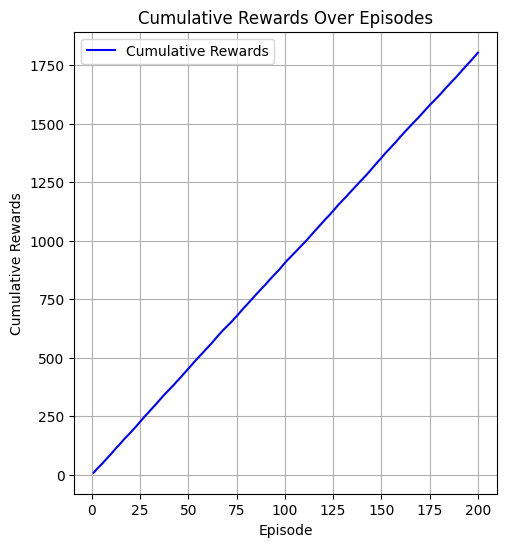

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(episodes, rewards_per_episode, label="Cumulative Rewards", color="blue")
plt.title("Cumulative Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Cumulative Rewards")
plt.grid(True)
plt.legend()

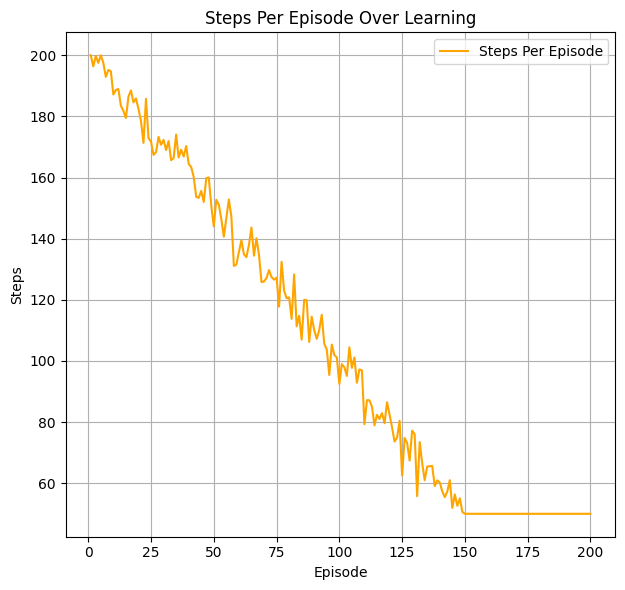

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(episodes, steps_per_episode, label="Steps Per Episode", color="orange")
plt.title("Steps Per Episode Over Learning")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
